In [1]:
# Import stuff
import torch as t
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader
from tqdm import tqdm

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = "notebook_connected"

import matplotlib.pyplot as plt


import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

import circuitsvis as cv
# Testing that the library works
cv.examples.hello("Lauren")



10 < Hours spent <15 (including background research)

First, import a dataset and plot the things we want to look at (layer norm, SoLU) for several examples 

In [2]:
from datasets import load_dataset
## a small sample set: microsoft research paraphrase dataset 
raw_dataset = load_dataset("glue", "mrpc")
#raw_quora_data = load_dataset("AlekseyKorshuk/quora-question-pairs")


Found cached dataset glue (/Users/lbg/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/3 [00:00<?, ?it/s]

In [47]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [3]:
# quora_prompts_1 = t.tensor([raw_quora_data['train'][k]['question1'] for k in range(len(raw_quora_data['train']))])
test_data = [raw_dataset['train'][k]['sentence1'] for k in range(raw_dataset['train'].num_rows)]


In [4]:
#Load the model
## turn off AD to save memory, since we're focusing on model inference here 
t.set_grad_enabled(False)

device = 'cuda' if t.cuda.is_available() else 'cpu'
SoLU_model = HookedTransformer.from_pretrained("NeelNanda/SoLU_1L512W_C4_Code", device=device)
# compare with a GeLU
GeLU_model = HookedTransformer.from_pretrained("NeelNanda/GELU_1L512W_C4_Code", device=device)

Loaded pretrained model NeelNanda/SoLU_1L512W_C4_Code into HookedTransformer
Loaded pretrained model NeelNanda/GELU_1L512W_C4_Code into HookedTransformer


In [5]:
# What do these models look like? 
print(SoLU_model.cfg.d_head,SoLU_model.cfg.d_mlp,SoLU_model.cfg.n_layers)
print(GeLU_model.cfg.d_head,GeLU_model.cfg.d_mlp,GeLU_model.cfg.n_layers)



64 2048 1
64 2048 1


In [6]:
test_prompt = test_data[5]

# loss is about the same 
print(SoLU_model(test_prompt,return_type = 'loss',prepend_bos=False),GeLU_model(test_prompt,return_type = 'loss',prepend_bos=False))

logits_SoLU, cache_SoLU = SoLU_model.run_with_cache(test_prompt,prepend_bos=False)
logits_GeLU, cache_GeLU = GeLU_model.run_with_cache(test_prompt,prepend_bos=False)

## The only difference between the models is the activation function - for layer norm, this is the added layer norm in the activations. For the first 2 (why 2?) layers norms, the result on a random input should be the same.
# Layer Norms act on the residual stream: At the beginning (ln1), before the mlp (ln2), and at the end (ln_final). For SoLU, there is an additional layer norm that acts in the mlp 

print(cache_SoLU.keys())
print(cache_GeLU.keys())



tensor(4.6911) tensor(5.4603)
dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_mid', 'blocks.0.mlp.ln.hook_scale', 'blocks.0.mlp.ln.hook_normalized', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'ln_final.hook_scale', 'ln_final.hook_normalized'])
dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.

In [7]:
# hook_normalized is redundant here, since there's also a default hook_post
assert t.all(cache_SoLU['blocks.0.mlp.ln.hook_normalized'] - cache_SoLU['blocks.0.mlp.hook_post'] ==0)

SoLU Activation function = lateral inhibition + ~sparsity + superlinearity 

- It's a super-linear function: de-incetivizes spreading features over multiple neurons, while increasing neuron activations by a bit, which gives ones that fire alone an edg.e 
- lateral inhibition -> approximate sparsity: softmax reduces the number of neurons that fire at the same time, leading to sparser (and more interpretable) activations

Caveats: This was trained on a more narrow dataset, and the authors are unsure how the activation function will generalize. I'd like to dig in here more and understand this better. Does this mean that the input I choose will effect my analysis? YES. When SoLU is applied to vectors with highly varying values, it makes the large ones larger and the small ones smaller. If they are roughly the same, it will result in smaller diffuse activations! 

-Other important points: in the original paper, they found that lowering polysemanticity via SoLU negatively effected model performance (more specifically, it performed as if it was a smaller network, as we should expect!)
-- This can be counteracted by following the SoLU activation with a LayerNorm. This will largely leave the monosemantic neurons (basis-aligned features) alone, but will scale up the diffuse, non-basis-aligned features. Basically, it eliminates the denominator of the softmax that was responsible for this repressive behavior. (So, we will compare the denominator of the softmax and the layer norm scale factor later. Compare with input!!)

tensor(6.9488)


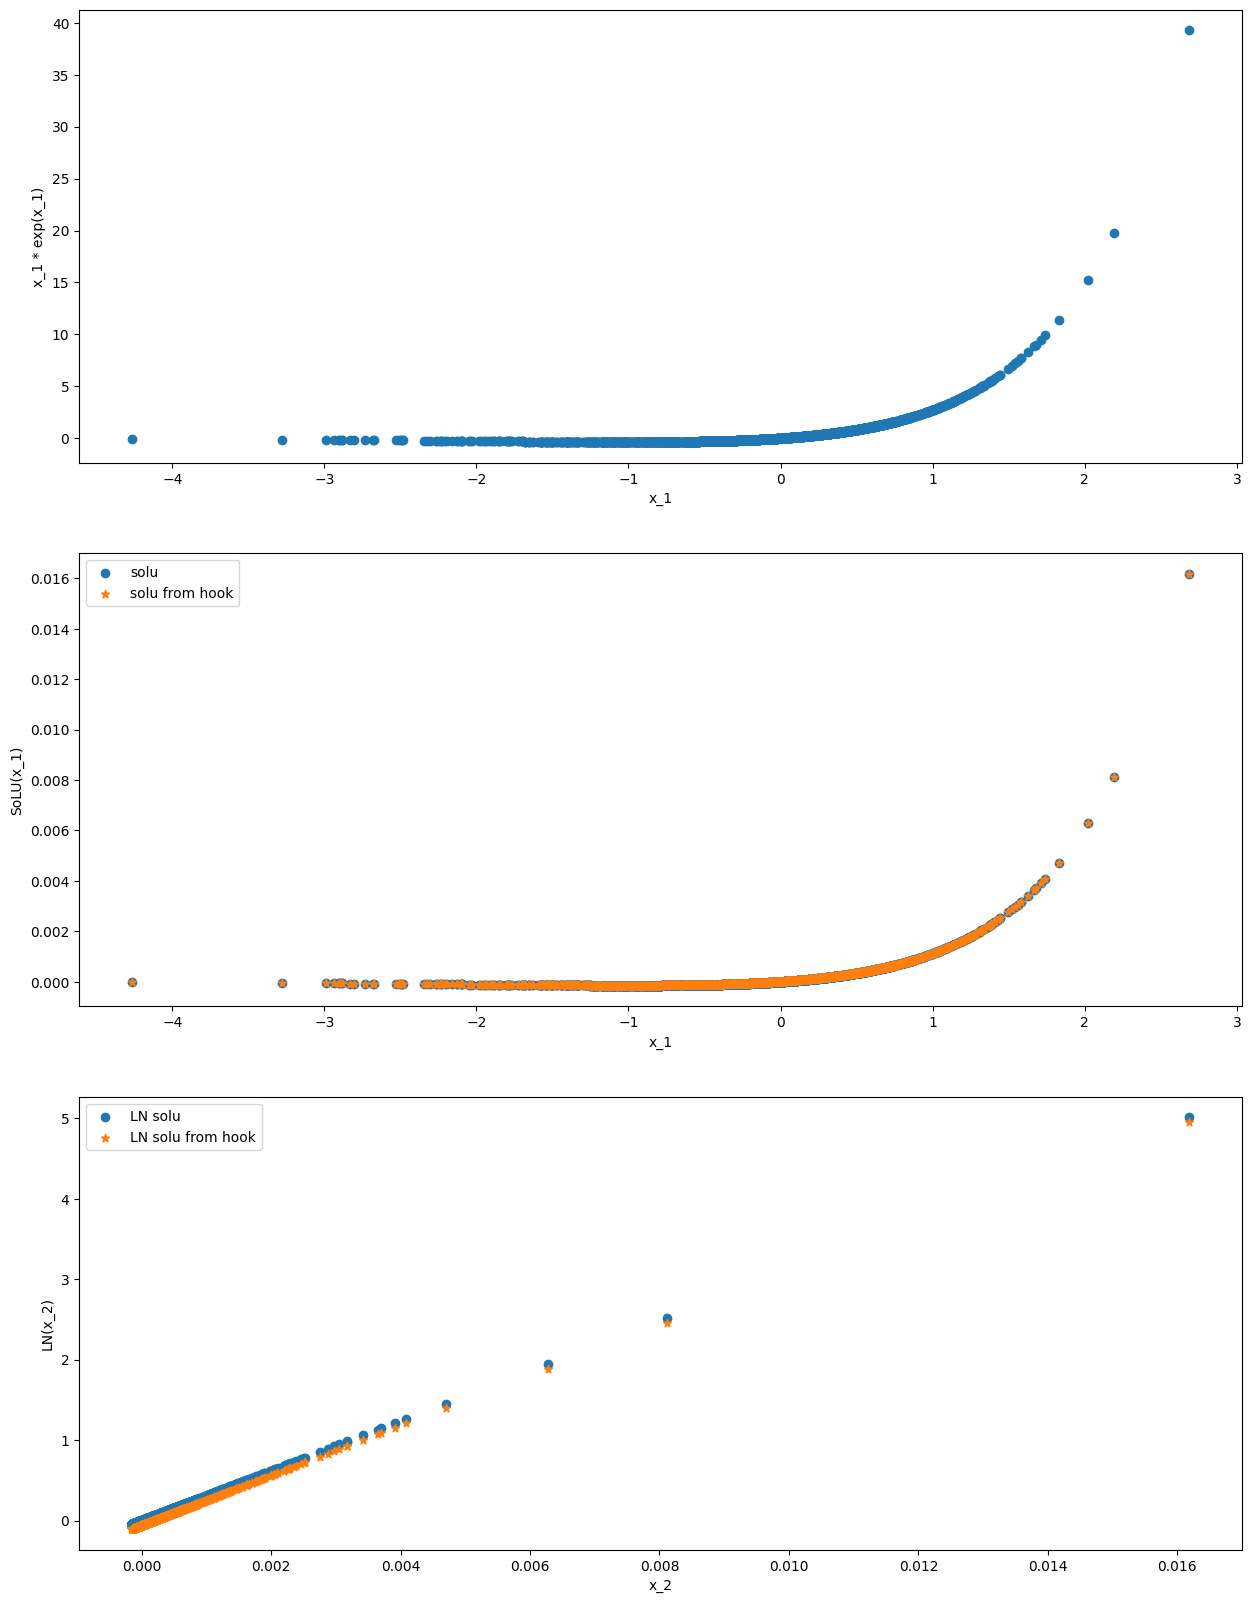

In [38]:
## Important: these models have different embeddings (because they are different models). We can compare performance, but it's hard to compare the broken down models themselves because they're fundamentally different (even though most of the pieces are the same). 

## plots in feature space (for a specific token)

## let's make sure I understand what the activation function of the solu model is doing 
# choose one input example (one token in the input sequence )
test_in = cache_SoLU['blocks.0.mlp.hook_pre'][0][5] ## linear transformation applied to residual stream
print(test_in.max() - test_in.min())

test_solu = (test_in * t.softmax(test_in, dim=0))

assert len(test_in) == SoLU_model.cfg.d_mlp # sum over the embedding space 
figs, axes = plt.subplots(3,1, figsize = (15,20))

# ### the input seems to vary enough for the softmax to send many of the values to zero, but we could hope for more sparsity (I have little intuition here)? 
# axes[0].scatter(test_in, t.softmax(test_in, dim=0))
# axes[0].set(xlabel="x_1", ylabel = "softmax(x_1)")

# Multiplying the vector by its exponential (softmax numerator). Scales everything up
axes[0].scatter(test_in,(test_in * t.exp(test_in)))
axes[0].set(xlabel="x_1", ylabel = "x_1 * exp(x_1)")

## The SoLU denominator - order of magnitude change happens higher up on the plot (more values "close" to 0)
axes[1].scatter(test_in,(test_in * t.softmax(test_in, dim=0)))
axes[1].scatter(test_in, cache_SoLU['blocks.0.mlp.hook_mid'][0][5], marker = '*')
axes[1].set(xlabel="x_1", ylabel = "SoLU(x_1)")
axes[1].legend(['solu', 'solu from hook'])
## LN is linear on x2 ... just separates the values a bit more
axes[2].scatter(test_solu,(test_solu)/t.sqrt(t.var(test_solu, dim=-1, keepdim=True, unbiased=False) + 1e-5))
axes[2].scatter(test_solu, cache_SoLU['blocks.0.mlp.hook_post'][0][5], marker = '*')
axes[2].set(xlabel="x_2", ylabel = "LN(x_2)")
axes[2].legend(['LN solu', 'LN solu from hook'])

# axes[4].scatter(test_in, cache_SoLU['blocks.0.mlp.hook_post'][0][5], marker = '*')
# axes[4].set(xlabel="x_1", ylabel = "LN(x_2)")




[Text(0.5, 0, 'x_out'), Text(0, 0.5, 'LN_scale(x_out)')]

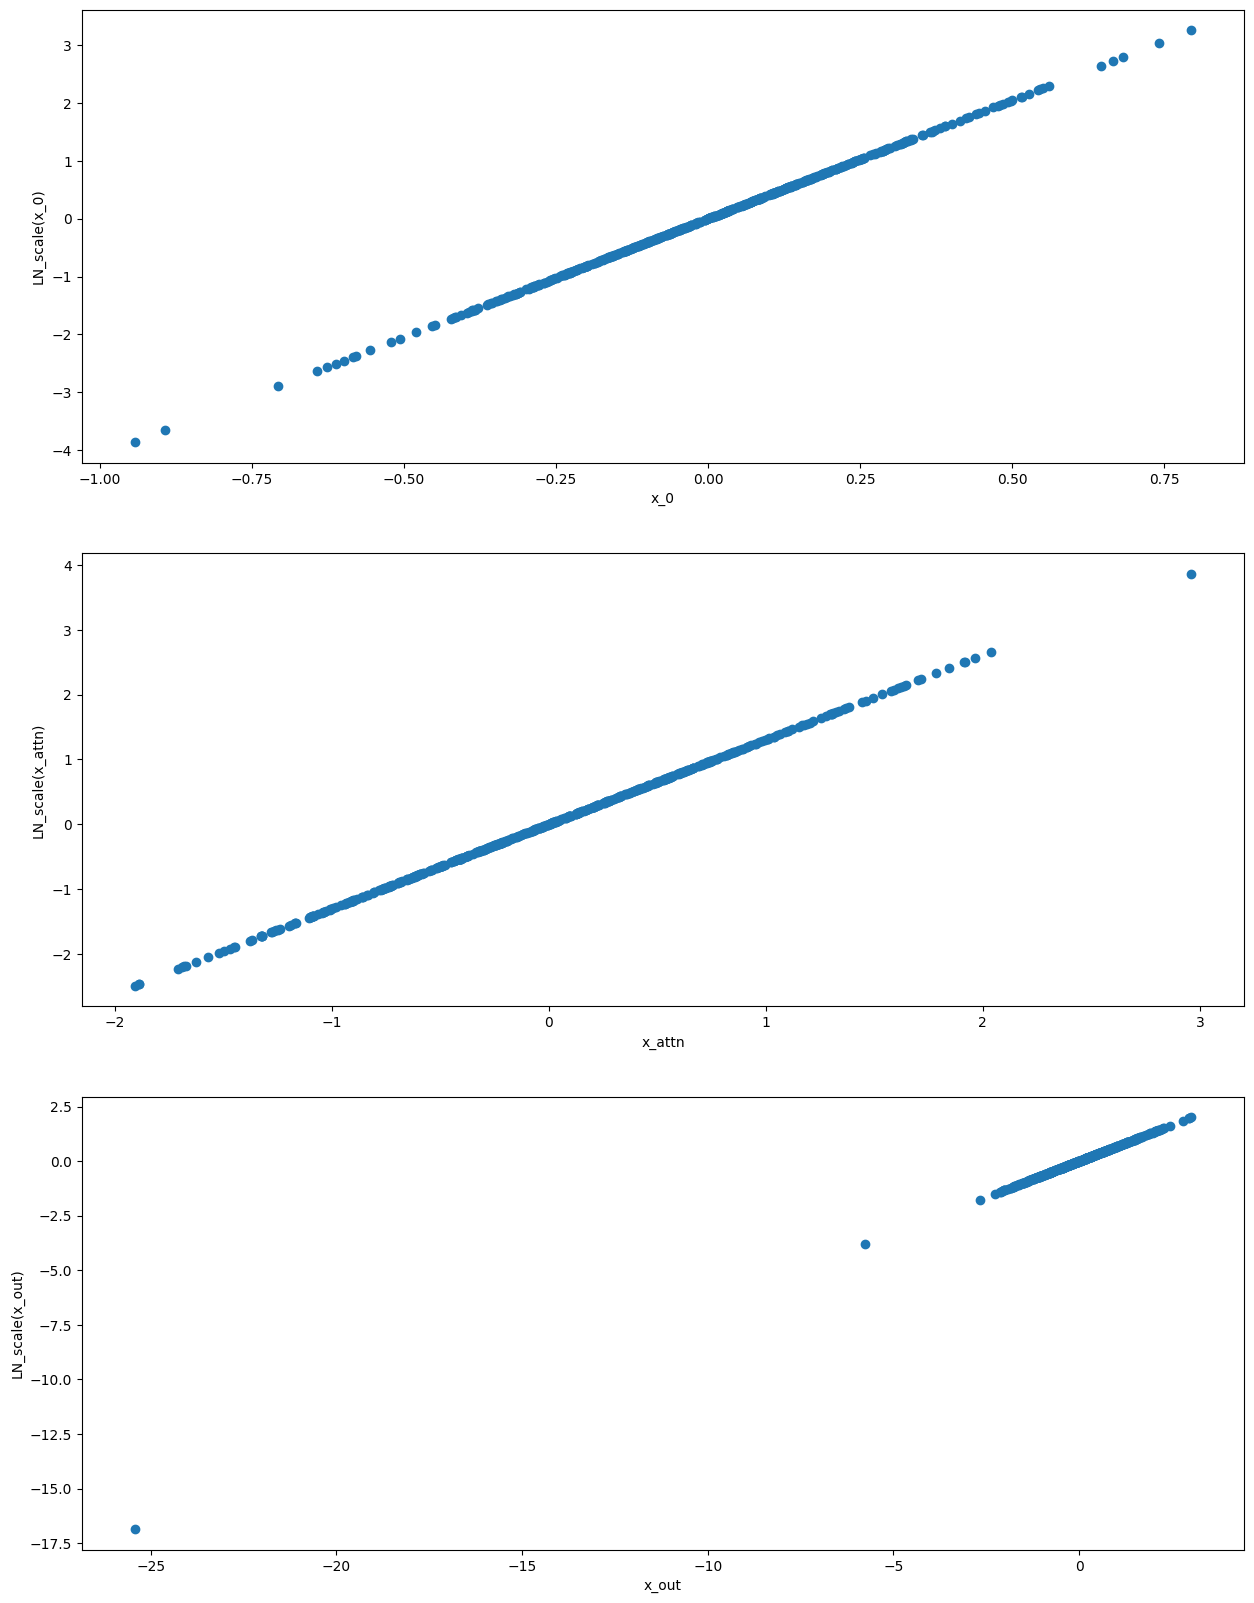

In [31]:
## Check that the layer norms at the beginning and the end of the model also linear. They "stretch" the points along the line
### to do: figure out how to color the points according to the input, so that you can see how they change throughout the network. 
n_tok = 5

figs, axes = plt.subplots(3,1, figsize = (15,20))

## Layer Norm on model Input
axes[0].scatter(cache_SoLU['blocks.0.hook_resid_pre'][0][n_tok], cache_SoLU['blocks.0.ln1.hook_normalized'][0][n_tok])
axes[0].set(xlabel="x_0", ylabel = "LN_scale(x_0)")

## LN after attention layer
axes[1].scatter(cache_SoLU['blocks.0.hook_resid_mid'][0][n_tok], cache_SoLU['blocks.0.ln2.hook_normalized'][0][n_tok])
axes[1].set(xlabel="x_attn", ylabel = "LN_scale(x_attn)")

# LN on block output
axes[2].scatter(cache_SoLU['blocks.0.hook_resid_post'][0][n_tok], cache_SoLU['ln_final.hook_normalized'][0][n_tok])
axes[2].set(xlabel="x_out", ylabel = "LN_scale(x_out)")



In [10]:
assert t.softmax(test_in, dim=0).sum() - 1.0 <1e-6

In [12]:
## running with hooks attempt - need to think a little more to cache the pieces we want efficiently

# SoLU_model.reset_hooks()
# hook_scales = t.tensor([[]])
# hook_sol_denom = t.tensor([[]])
# def cache_LN_scales_aux(tensor, hook, i):
#     t.concat((hook_scales, tensor.flatten().mean()))
# def cache_solu_denom(tensor, hook):
#     denom =t.exp(tensor[0]).sum(-1)
#     t.concat((hook_sol_denom, denom), dim=0)

# for i in tqdm(range(len(test_data))):
#     def cache_LN_scales(tensor, hook):
#         hook_scales[i]
#     SoLU_model.run_with_hooks(test_data[i],
#                            fwd_hooks = [('blocks.0.mlp.ln.hook_scale', cache_LN_scales)])
#     SoLU_model.run_with_hooks(test_data[i],
#                            fwd_hooks = [('blocks.0.mlp.hook_pre', cache_solu_denom)])

## but for now, try caching everything and see what happens 

logits = []
caches = []
for i in tqdm(range(len(test_data))):
    logits_i, cache_i = SoLU_model.run_with_cache(test_data[i],prepend_bos=False)
    caches.append(cache_i)



100%|██████████| 3668/3668 [00:29<00:00, 123.70it/s]


In [13]:
# a = cache_SoLU['blocks.0.mlp.ln.hook_scale'][0].flatten()
# b = t.exp(cache_SoLU['blocks.0.mlp.hook_pre'][0]).sum(-1)
# t.concat((a,b), dim=0).shape

def get_LN_scale(cache):
    return cache['blocks.0.mlp.ln.hook_scale'][0].flatten()

def get_solu_denom(cache):
    return t.exp(cache['blocks.0.mlp.hook_pre'][0]).sum(-1).flatten()

LN_scales = t.concat(tuple(get_LN_scale(caches[k]) for k in range(len(caches))))
SoLU_denoms = t.concat(tuple(get_solu_denom(caches[k]) for k in range(len(caches))))



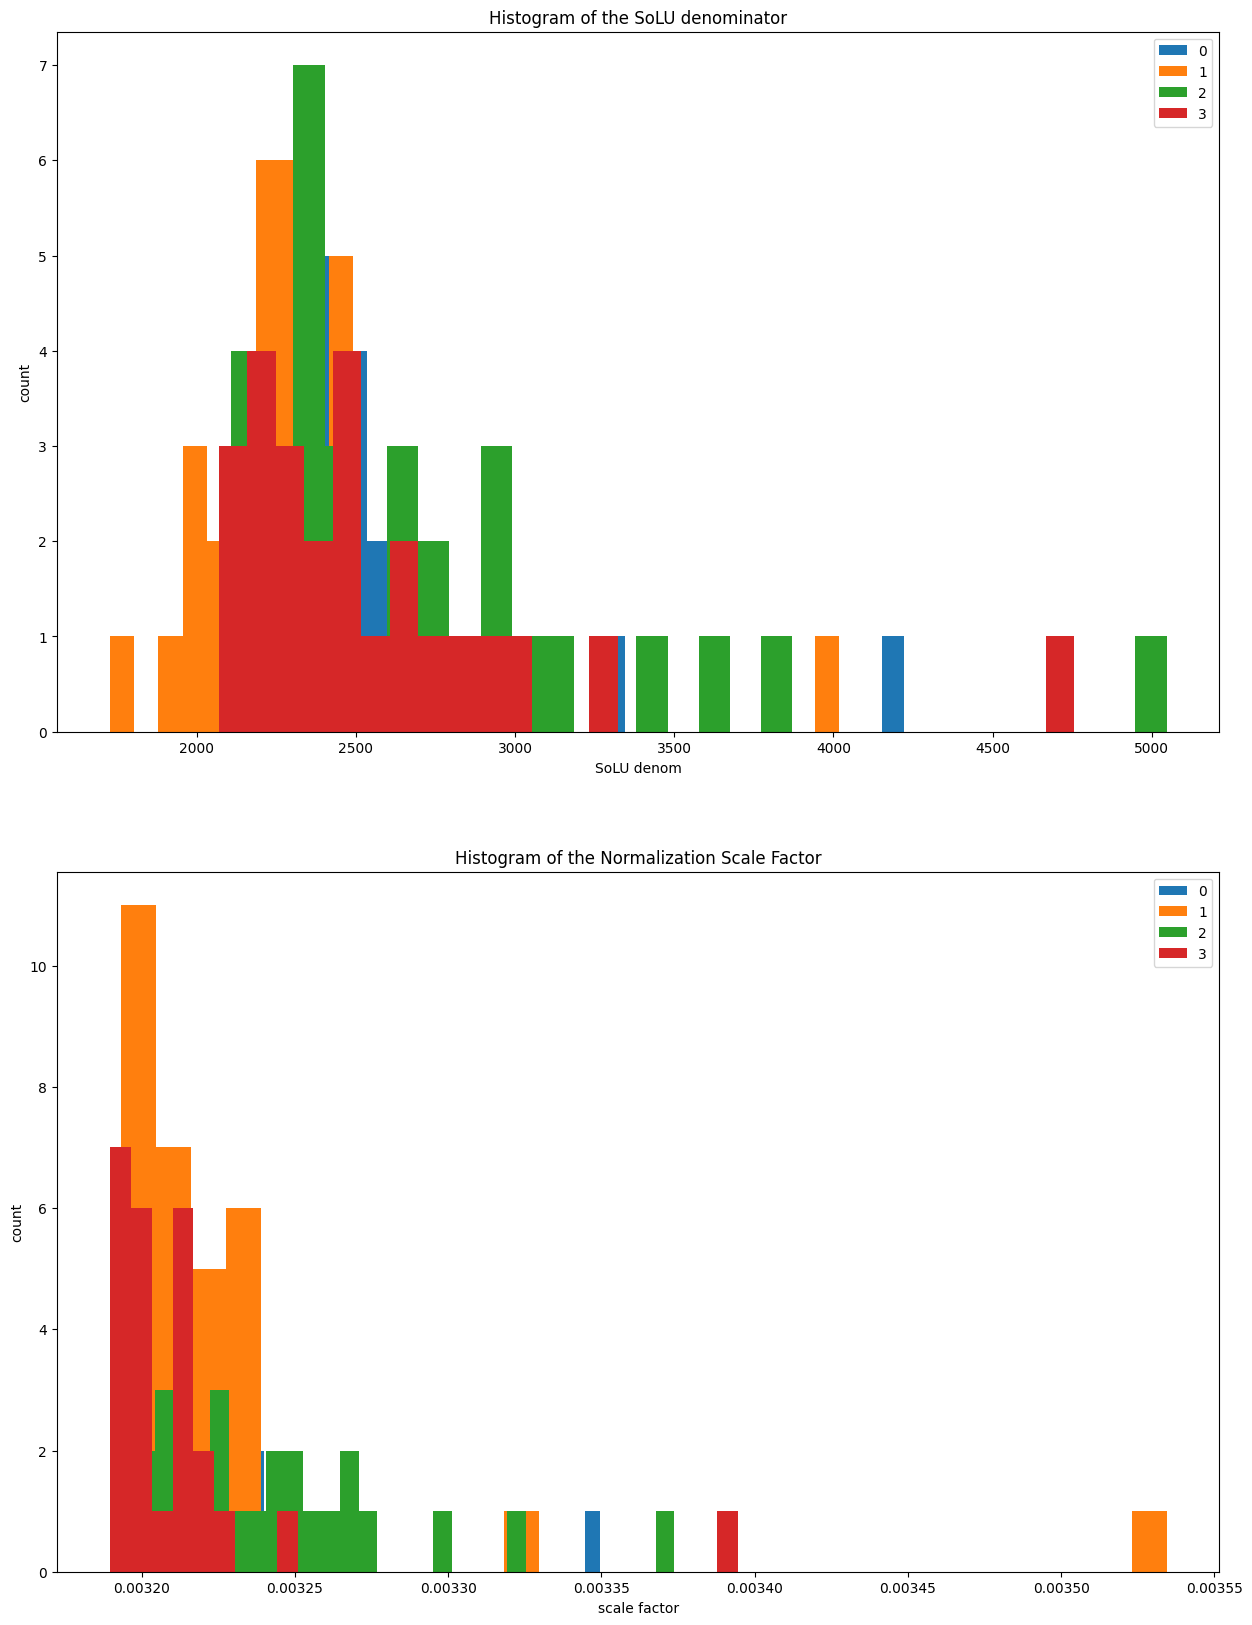

In [49]:
_, axes = plt.subplots(2,1, figsize = (15,20) )
for i, cache in enumerate(caches[1000:1004]):
    axes[0].hist(get_solu_denom(cache), bins=30,stacked = True, label = i)
    axes[0].set(title = 'Histogram of the SoLU denominator', ylabel = "count",xlabel = "SoLU denom")
    axes[0].legend()

    axes[1].hist(get_LN_scale(cache), bins=30, stacked=True, label=i)
    axes[1].set(title = 'Histogram of the Normalization Scale Factor', ylabel = "count",xlabel = "scale factor")
    axes[1].legend()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 1000.0)

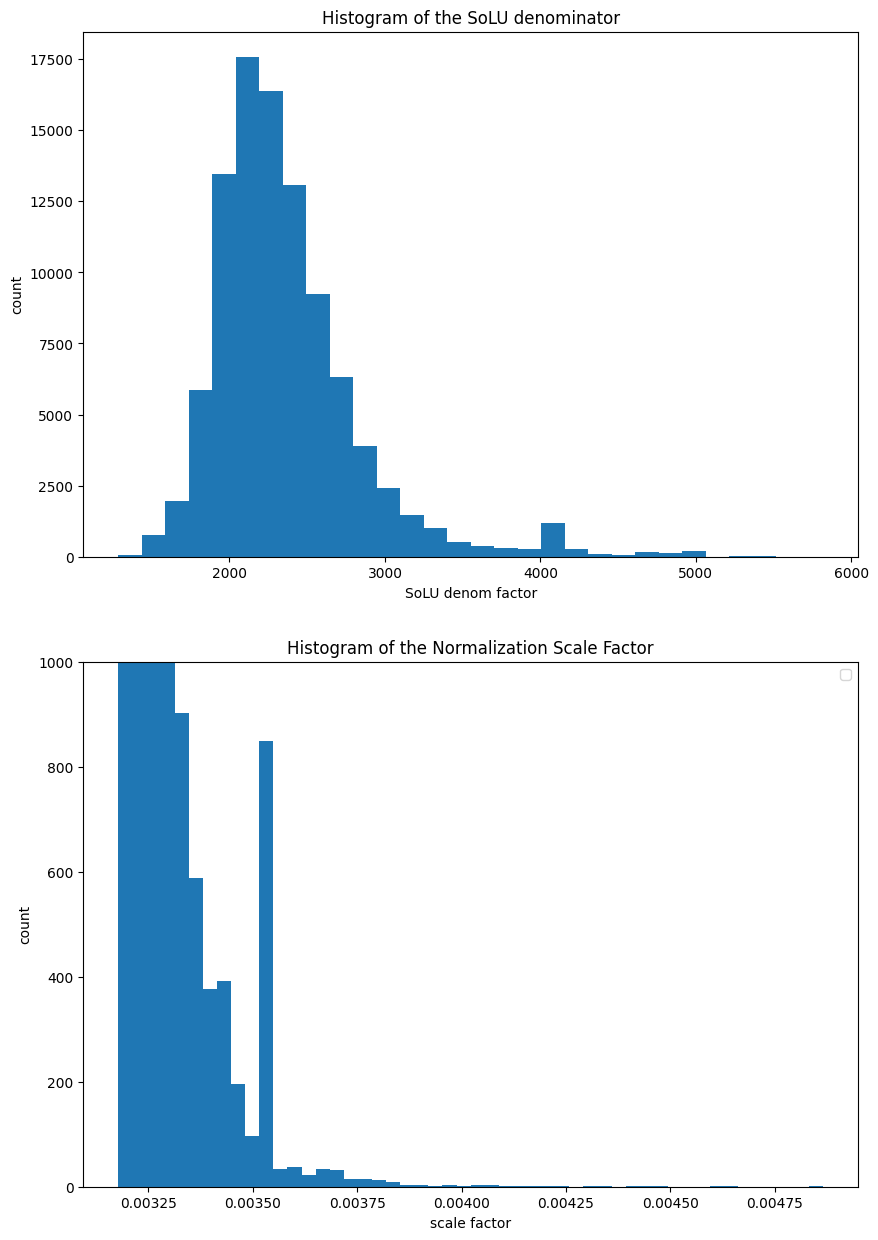

In [48]:
_, full_ax = plt.subplots(2,1, figsize = (10,15))

full_ax[0].hist(SoLU_denoms, bins=30)
full_ax[0].set(title = 'Histogram of the SoLU denominator', ylabel = "count",xlabel = "SoLU denom factor")
axes[0].legend()

full_ax[1].hist(LN_scales, bins=50)
full_ax[1].set(title = 'Histogram of the Normalization Scale Factor', ylabel = "count",xlabel = "scale factor")
full_ax[1].legend()

plt.ylim([0,1000])


[Text(0.5, 1.0, 'Histogram of the Normalization Scale Factor: ln_final'),
 Text(0.5, 0, 'scale factor'),
 Text(0, 0.5, 'count')]

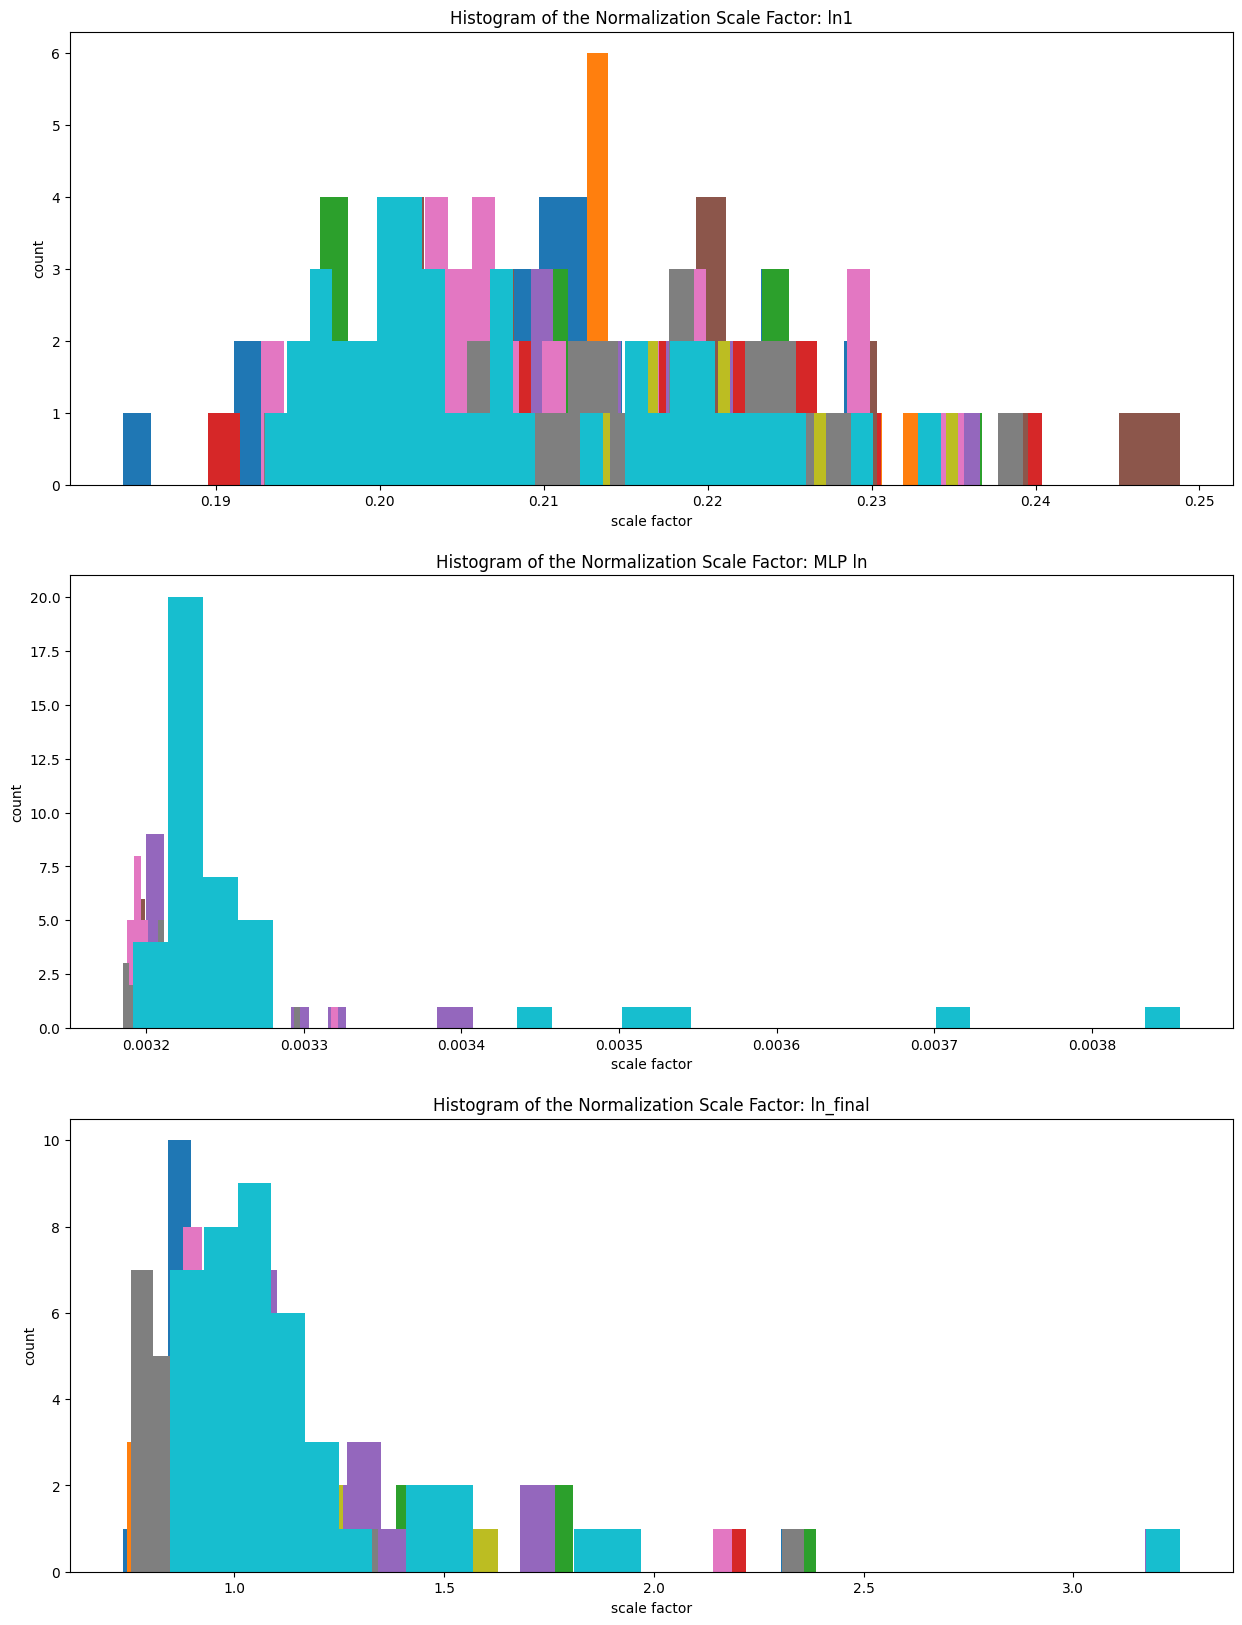

In [17]:
### compare the MLP layer norm with the other layer norms in the network, so if any pattern arises 

_, ax = plt.subplots(3,1,figsize = (15,20))
n_bins = 30
for cache in caches[-10:]:
    ax[0].hist(cache['blocks.0.ln1.hook_scale'][0].flatten(), bins=n_bins)
    ax[1].hist(get_LN_scale(cache),bins=n_bins)
    ax[2].hist(cache['ln_final.hook_scale'][0].flatten(),bins=n_bins)
ax[0].set(title = 'Histogram of the Normalization Scale Factor: ln1', xlabel='scale factor', ylabel='count')
ax[1].set(title = 'Histogram of the Normalization Scale Factor: MLP ln', xlabel='scale factor', ylabel='count')
ax[2].set(title = 'Histogram of the Normalization Scale Factor: ln_final', xlabel='scale factor', ylabel='count')


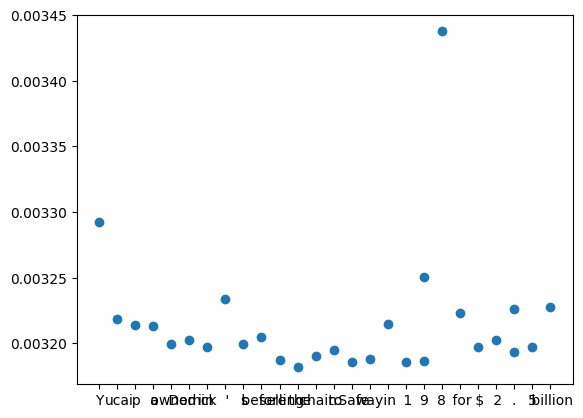

In [18]:
## try to pick out the tokens. First for a single prompt 
#### First thought: BOS seems to be higher than the other values.  Running without it gets rid of a single, tall bar to the right of the plot, that seems to be contributing from many (all) prompts. Does this mean that each token has the same layer_norm_denom, regardless of which prompt it's coming from? How can this be? 


idx = 1


tc = caches[idx]
tp = test_data[idx]
tokens = SoLU_model.to_tokens(tp,prepend_bos=False).squeeze()
x = [SoLU_model.tokenizer.decode(t,prepend_bos=False) for t in tokens]
plt.scatter(x,get_LN_scale(caches[idx]))
#plt.scatter(x,get_solu_denom(caches[idx]))



To do: 
1. pick a token across all prompt examples, and analyze the above nonlinearities 
2. look at the distributions for GeLU and SoLU activations (unembed first?) -- what is the difference between the two? 
3. Perform an analysis like the fake interpretability paper: pick a neuron, find top activating examples, and analyze the feature space (nonlinearities above and to see if any human interpretable groups arise), to try and find some sort of connection/ context for layernorm in solu. Does the neuron retain the same meaning from Softmax -> Layernorm?  
4. Try on different datasets. 